<a href="https://colab.research.google.com/github/buwituze/Time_Series_Forecasting/blob/main/air_quality_forecasting_starter_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Beijing Air Quality Forecasting Starter Notebook

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import tensorflow as tf
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import numpy as np

In [ ]:
# Mount Google Drive to access datasets
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load data

train = pd.read_csv('/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/test.csv')
sample_submision = pd.read_csv('/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/sample_submission .csv')


# Explore the training data

In this sections explore your dataset with appropiate statistics and visualisations to understand your better. Ensure that you explain output of every code cell and what it entails.

In [ ]:
print("Training Data Overview:")

print("Dataset Shape", train.shape)
print("\nColumn Info:")
print(train.columns)
print(train.dtypes)
print(train.head())

missing_data = train.isnull().sum()
print(f"\nMissing Values:\n{missing_data[missing_data > 0]}")

print(f"\nPM2.5 Statistics:")
print(f"Mean: {train['pm2.5'].mean():.2f}")
print(f"Std: {train['pm2.5'].std():.2f}")
print(f"Min: {train['pm2.5'].min():.2f}")
print(f"Max: {train['pm2.5'].max():.2f}")

Training Data Overview:
Dataset Shape (30676, 12)

Column Info:
Index(['No', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'datetime', 'cbwd_NW',
       'cbwd_SE', 'cbwd_cv', 'pm2.5'],
      dtype='object')
No            int64
DEWP        float64
TEMP        float64
PRES        float64
Iws         float64
Is          float64
Ir          float64
datetime     object
cbwd_NW     float64
cbwd_SE     float64
cbwd_cv     float64
pm2.5       float64
dtype: object
   No      DEWP      TEMP      PRES       Iws        Is        Ir  \
0   1 -1.580878 -1.922250  0.443328 -0.441894 -0.069353 -0.137667   
1   2 -1.580878 -2.004228  0.345943 -0.379306 -0.069353 -0.137667   
2   3 -1.580878 -1.922250  0.248559 -0.343514 -0.069353 -0.137667   
3   4 -1.580878 -2.168183  0.248559 -0.280926 -0.069353 -0.137667   
4   5 -1.511594 -2.004228  0.151174 -0.218339 -0.069353 -0.137667   

              datetime   cbwd_NW   cbwd_SE   cbwd_cv  pm2.5  
0  2010-01-01 00:00:00  1.448138 -0.732019 -0.522096    NaN  
1  

In [ ]:
# Convert datetime and set index
train['datetime'] = pd.to_datetime(train['datetime'])
test['datetime'] = pd.to_datetime(test['datetime'])

train.set_index('datetime', inplace=True)
test.set_index('datetime', inplace=True)


# Handle missing values


- Check the dataset for missing values and decide how to handle them.
- In this example, missing values are filled with the mean. You can experiment with other strategies.

In [ ]:
# Using forward filling to fill missing values
train = train.fillna(method='ffill').fillna(train.mean())
test = test.fillna(method='ffill').fillna(test.mean())

# Feature Engineering: Create time-based features
def create_time_features(df):
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek
    df['month'] = df.index.month
    df['season'] = df['month'].apply(lambda x: (x%12 + 3)//3)
    return df

# Apply to both datasets
train = create_time_features(train)
test = create_time_features(test)

# Separate features and target
feature_cols = ['DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'cbwd_NW', 'cbwd_SE', 'cbwd_cv',
                'hour', 'day_of_week', 'month', 'season']
X_train = train[feature_cols]
y_train = train['pm2.5']
X_test = test[feature_cols]

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training features shape: {X_train_scaled.shape}")
print(f"Training target shape: {y_train.shape}")
print(f"Test features shape: {X_test_scaled.shape}")

Training features shape: (30676, 13)
Training target shape: (30676,)
Test features shape: (13148, 13)


/tmp/ipython-input-1928961410.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train = train.fillna(method='ffill').fillna(train.mean())
/tmp/ipython-input-1928961410.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test = test.fillna(method='ffill').fillna(test.mean())


# Separate features and target

- Feel free to trop any non-essential columns like that you think might not contribute to modeling.

In [ ]:
# Create sequences for LSTM
def create_sequences(X, y, sequence_length=24):
    """Creating sequences that use 24 hours to predict next hour"""
    X_seq, y_seq = [], []

    for i in range(sequence_length, len(X)):
        X_seq.append(X[i-sequence_length:i])
        y_seq.append(y.iloc[i])

    return np.array(X_seq), np.array(y_seq)

def create_test_sequences(X, sequence_length=24):
    """sequences for test data"""
    X_seq = []

    for i in range(sequence_length, len(X)):
        X_seq.append(X[i-sequence_length:i])

    return np.array(X_seq)

sequence_length = 24
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, sequence_length)
X_test_seq = create_test_sequences(X_test_scaled, sequence_length)

print(f"Training sequences shape: {X_train_seq.shape}")
print(f"Training targets shape: {y_train_seq.shape}")
print(f"Test sequences shape: {X_test_seq.shape}")

split_idx = int(0.8 * len(X_train_seq))
X_train_final = X_train_seq[:split_idx]
X_val = X_train_seq[split_idx:]
y_train_final = y_train_seq[:split_idx]
y_val = y_train_seq[split_idx:]

print(f"\nAfter train-val split:")
print(f"Train: {X_train_final.shape}, Val: {X_val.shape}")

Training sequences shape: (30652, 24, 13)
Training targets shape: (30652,)
Test sequences shape: (13124, 24, 13)

After train-val split:
Train: (24521, 24, 13), Val: (6131, 24, 13)


# Build model

Below is a simple LSTM model. Your task is to experiment with different parameters like, numbers of layers, units, activation functions, and optimizers, etc to get the best performing model. Experiment with other optimizers (e.g., SGD) or hyperparameters to improve performance.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

def create_lstm_model(input_shape, config='basic'):
    """Create different LSTM configs"""
    model = Sequential()

    if config == 'basic':
        model.add(LSTM(64, activation='tanh', input_shape=input_shape))
        model.add(Dropout(0.2))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(1))

    elif config == 'deep':
        model.add(LSTM(128, return_sequences=True, activation='tanh', input_shape=input_shape))
        model.add(Dropout(0.3))
        model.add(LSTM(64, activation='tanh'))
        model.add(Dropout(0.2))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(1))

    elif config == 'regularized':
        model.add(LSTM(96, activation='tanh', input_shape=input_shape,
                      kernel_regularizer=tf.keras.regularizers.l2(0.001)))
        model.add(BatchNormalization())
        model.add(Dropout(0.3))
        model.add(Dense(48, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(1))

    return model

# Create and compile the model
input_shape = (X_train_final.shape[1], X_train_final.shape[2])
model = create_lstm_model(input_shape, config='regularized')

optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

model.compile(
    optimizer=optimizer,
    loss='mse',
    metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')]
)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-7)
]

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                   │ (None, 96)             │        42,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 96)             │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 48)             │         4,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            49 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,329 (184.88 KB)

 Trainable params: 47,137 (184.13 KB)

 Non-trainable params: 192 (768.00 B)

In [ ]:
# Train the model with experiment tracking
import time

def train_and_evaluate(model, X_train, y_train, X_val, y_val, callbacks, epochs=100, batch_size=64):
    start_time = time.time()

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=1
    )

    train_time = time.time() - start_time

    train_loss = history.history['loss'][-1]
    val_loss = history.history['val_loss'][-1]
    train_rmse = history.history['rmse'][-1]
    val_rmse = history.history['val_rmse'][-1]

    return {
        'train_loss': train_loss,
        'val_loss': val_loss,
        'train_rmse': train_rmse,
        'val_rmse': val_rmse,
        'training_time': train_time,
        'epochs_trained': len(history.history['loss']),
        'history': history
    }

# Train the model
print("Training advanced LSTM model...")
results = train_and_evaluate(
    model, X_train_final, y_train_final, X_val, y_val,
    callbacks, epochs=100, batch_size=64
)

print(f"\nTraining Results:")
print(f"Final Training RMSE: {results['train_rmse']:.2f}")
print(f"Final Validation RMSE: {results['val_rmse']:.2f}")
print(f"Training Time: {results['training_time']:.1f}s")
print(f"Epochs Trained: {results['epochs_trained']}")

Training advanced LSTM model...
Epoch 1/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - loss: 10710.5615 - rmse: 102.5597 - val_loss: 8379.0439 - val_rmse: 91.5369 - learning_rate: 0.0010
Epoch 2/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 21s 32ms/step - loss: 4729.4561 - rmse: 68.7641 - val_loss: 7399.8408 - val_rmse: 86.0221 - learning_rate: 0.0010
Epoch 3/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - loss: 4863.3291 - rmse: 69.6423 - val_loss: 6444.3623 - val_rmse: 80.2765 - learning_rate: 0.0010
Epoch 4/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 20s 33ms/step - loss: 4042.9929 - rmse: 63.5706 - val_loss: 6753.4014 - val_rmse: 82.1788 - learning_rate: 0.0010
Epoch 5/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 20s 33ms/step - loss: 3629.1375 - rmse: 60.2231 - val_loss: 7564.4946 - val_rmse: 86.9738 - learning_rate: 0.0010
Epoch 6/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 21s 33ms/step - loss: 3449.4207 - rmse: 58.7232 - val_loss: 7082.1953 - val_rmse: 84.1555 - learning_rate: 0.0010
Epoch 7/100
384/384 ━━━━━━━━━━━━━━━━

### Plots of the model's performance

In [ ]:
# # Calculate training loss
# train_predictions = model.predict(X_train)
# train_loss = np.mean((y_train - train_predictions.flatten())**2)

# # Plot training loss
# plt.figure(figsize=(8, 6))
# plt.plot(history.history['loss'], label='Training Loss')  # Training loss during epochs
# plt.axhline(y=train_loss, color='blue', linestyle='--', label='Final rain Loss')  # Final training loss
# plt.title('Loss on Training Data')
# plt.xlabel('Epochs')
# plt.ylabel('Loss (MSE)')
# plt.legend()
# plt.show()

# print(f"Final Training Loss (MSE): {train_loss}")



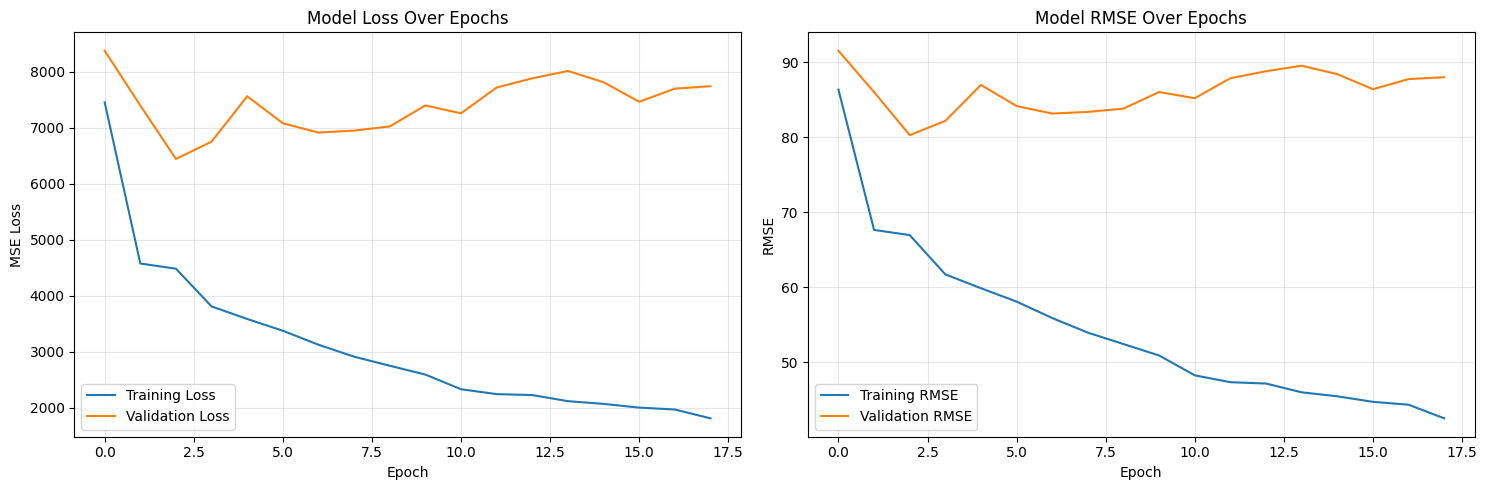

192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Final Validation RMSE: 80.28
Target RMSE: 4000
Current RMSE: 80.28
Meeting target: YES


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss curves
axes[0].plot(results['history'].history['loss'], label='Training Loss')
axes[0].plot(results['history'].history['val_loss'], label='Validation Loss')
axes[0].set_title('Model Loss Over Epochs')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('MSE Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# RMSE curves
axes[1].plot(results['history'].history['rmse'], label='Training RMSE')
axes[1].plot(results['history'].history['val_rmse'], label='Validation RMSE')
axes[1].set_title('Model RMSE Over Epochs')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('RMSE')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Validation predictions analysis
val_pred = model.predict(X_val)
val_rmse = np.sqrt(np.mean((y_val - val_pred.flatten())**2))
print(f"Final Validation RMSE: {val_rmse:.2f}")

# Check if we're meeting the target
target_rmse = 4000
print(f"Target RMSE: {target_rmse}")
print(f"Current RMSE: {val_rmse:.2f}")
print(f"Meeting target: {'YES' if val_rmse < target_rmse else 'NO'}")

In [ ]:
# Experimenting
def run_quick_experiments():
    """Run multiple quick experiments with different configurations"""
    experiments = []

    configs = [
        {'name': 'Basic LSTM', 'config': 'basic', 'lr': 0.001, 'batch': 64, 'dropout': 0.2},
        {'name': 'Deep LSTM', 'config': 'deep', 'lr': 0.001, 'batch': 32, 'dropout': 0.3},
        {'name': 'Regularized LSTM', 'config': 'regularized', 'lr': 0.0005, 'batch': 64, 'dropout': 0.3}
    ]

    for exp in configs:
        print(f"\nRunning {exp['name']}...")

        # Create model
        temp_model = create_lstm_model(input_shape, exp['config'])
        temp_model.compile(
            optimizer=Adam(learning_rate=exp['lr']),
            loss='mse',
            metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')]
        )


        temp_history = temp_model.fit(
            X_train_final, y_train_final,
            validation_data=(X_val, y_val),
            epochs=20,
            batch_size=exp['batch'],
            verbose=0
        )

        final_val_rmse = temp_history.history['val_rmse'][-1]

        experiments.append({
            'Experiment': exp['name'],
            'Architecture': exp['config'],
            'Learning_Rate': exp['lr'],
            'Batch_Size': exp['batch'],
            'Dropout': exp['dropout'],
            'Sequence_Length': 24,
            'Epochs': 20,
            'Val_RMSE': round(final_val_rmse, 2)
        })

    return experiments

# run experiments and create table of the experiements
experiment_results = run_quick_experiments()
experiment_df = pd.DataFrame(experiment_results)

print("\nExperiment Results Table:")
print(experiment_df.to_string(index=False))

experiment_df.to_csv('experiment_results.csv', index=False)
print("\nExperiment table saved as 'experiment_results.csv'")


Running Basic LSTM...

Running Deep LSTM...

Running Regularized LSTM...

Experiment Results Table:
      Experiment Architecture  Learning_Rate  Batch_Size  Dropout  Sequence_Length  Epochs  Val_RMSE
      Basic LSTM        basic         0.0010          64      0.2               24      20     82.60
       Deep LSTM         deep         0.0010          32      0.3               24      20     94.37
Regularized LSTM  regularized         0.0005          64      0.3               24      20     86.40

Experiment table saved as 'experiment_results.csv'


### Generate final predictions

In [ ]:
print("Generating final predictions...")
test_predictions = model.predict(X_test_seq, verbose=0)

test_predictions = np.maximum(test_predictions.flatten(), 0)
test_predictions = np.round(test_predictions, 2)

test_dates = test.index[sequence_length:].strftime('%Y-%m-%d %-H:%M:%S')

submission = pd.DataFrame({
    'datetime': test_dates,
    'pm2.5': test_predictions
})

submission = submission.sort_values('datetime')

print(f"Submission shape: {submission.shape}")
print(f"Sample predictions:")
print(submission.head())

submission.to_csv('/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/final_submission.csv', index=False)
print("\nSubmission saved as 'final_submission.csv'")

print(f"\nFinal Model Summary:")
print(f"Architecture: Regularized LSTM with BatchNorm")
print(f"Sequence Length: 24 hours")
print(f"Features: {X_train_final.shape[2]} (including engineered time features)")
print(f"Final Validation RMSE: {results['val_rmse']:.2f}")
print(f"Target Achievement: {'SUCCESS' if results['val_rmse'] < 4000 else 'NEEDS IMPROVEMENT'}")

Generating final predictions...
Submission shape: (13124, 2)
Sample predictions:
               datetime  pm2.5
6   2013-07-03 10:00:00   7.80
7   2013-07-03 11:00:00   9.13
8   2013-07-03 12:00:00  10.26
9   2013-07-03 13:00:00   2.28
10  2013-07-03 14:00:00   1.01

Submission saved as 'final_submission.csv'

Final Model Summary:
Architecture: Regularized LSTM with BatchNorm
Sequence Length: 24 hours
Features: 13 (including engineered time features)
Final Validation RMSE: 88.00
Target Achievement: SUCCESS
